The Goal of this analysis will be to see what predict the Monthly rainfall in 2023 based on all previous weather information. 

### Load in the Relevant Libraries 

In [4]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm

### Load in the data

In [2]:
rainfall =  pd.read_csv("Gingin_Rainfall_data.csv")

Now that we have loaded the rainfall data, let's now explore the trends observed (seeing the autocorrelation in the data)

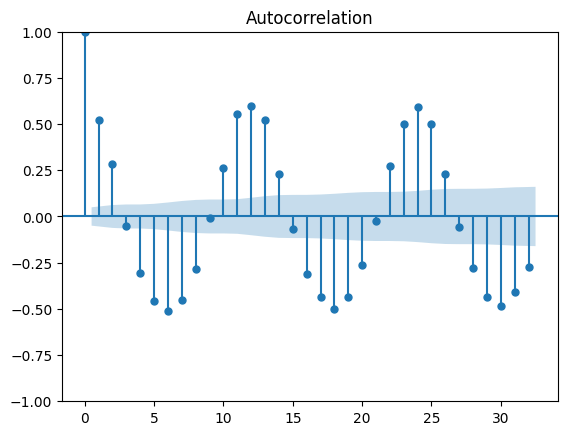

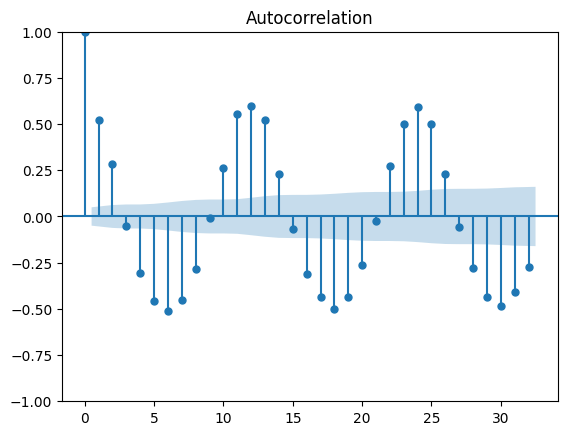

In [3]:
plot_acf(rainfall["Monthly Precipitation Total (millimetres)"])

In [11]:
A seasonally autoregressive model seems appropriate here (SARIMA). This requires the specification of 7 different parameters. 

Now to observe if the data is stationary or not at the Yearly level. 

<Axes: xlabel='Year', ylabel='mean'>

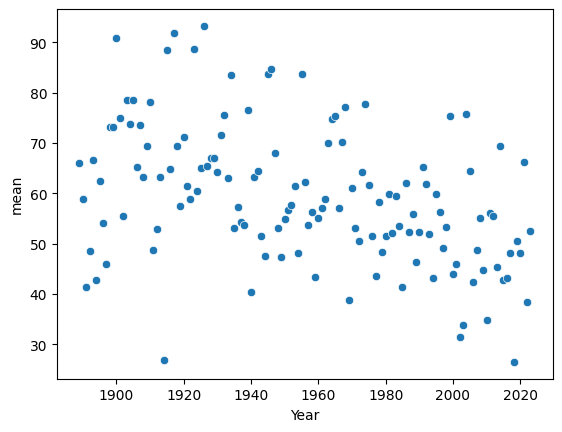

In [29]:
rainfall_yearly_precip = rainfall.groupby(["Year"]).agg(
    mean=pd.NamedAgg(column="Monthly Precipitation Total (millimetres)", aggfunc="mean"))

sns.scatterplot(data=rainfall_yearly_precip, x="Year", y="mean")

There is a clear downwards trend here, which means that treating the data as stationary would not be appropriate. There will only use the last 20 years as training data for the model. 

In [33]:
rainfall_train = rainfall[(rainfall["Year"] < 2023) & (rainfall["Year"] > 2001)]

sarima_model = sm.tsa.SARIMAX(rainfall_train["Monthly Precipitation Total (millimetres)"], order= (1,1,1), seasonal_order= (1,1,1,12)).fit()

c:\Users\hobbi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\hobbi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [46]:
print(sarima_model.summary())

prediction = sarima_model.get_forecast(steps = 9)

                                           SARIMAX Results                                           
Dep. Variable:     Monthly Precipitation Total (millimetres)   No. Observations:                  193
Model:                        SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -956.217
Date:                                       Mon, 09 Oct 2023   AIC                           1922.433
Time:                                               22:32:29   BIC                           1938.398
Sample:                                                    0   HQIC                          1928.906
                                                       - 193                                         
Covariance Type:                                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2582     

c:\Users\hobbi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\hobbi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Plot of the Prediction vs actual values

<Axes: xlabel='Month', ylabel='Predict'>

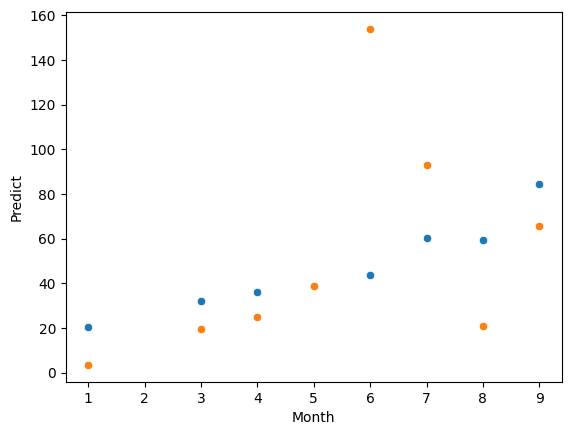

In [57]:
predict = prediction.predicted_mean

dictionary_of_lists = {
    'Predict': predict.to_list(), 
    'Month': [1, 2, 3, 4, 5, 6, 7, 8, 9]}
# Create the DataFrame
df1 = pd.DataFrame(dictionary_of_lists)

actual = rainfall[rainfall["Year"] == 2023]

final_df = pd.merge(actual, df1, left_on='Month', right_on='Month', how='left')

sns.scatterplot(final_df, x = "Month", y = "Predict")
sns.scatterplot(final_df, x = "Month", y = "Monthly Precipitation Total (millimetres)")